# LSTM (TSAI) Baseline Model - 4 bins

This LSTM model is based on the [tsai library](https://timeseriesai.github.io/tsai/).

In [ ]:
%%time
import random
import pandas as pd
import numpy as np
import torch
from tsai.all import *
from pathlib import Path
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test shape <class 'pandas.core.frame.DataFrame'> (33783, 91) <class 'pandas.core.frame.DataFrame'> (8418, 91)


epoch,train_loss,valid_loss,accuracy,time
0,1.291332,1.267684,0.415063,00:16
1,1.138165,1.160135,0.455334,00:19
2,1.127357,1.174511,0.447493,00:18
3,1.116565,1.155104,0.454146,00:18
4,1.124688,1.151581,0.457116,00:18
5,1.128561,1.162158,0.438584,00:20
6,1.094869,1.142839,0.463887,00:18
7,1.075842,1.150567,0.461036,00:18
8,1.090504,1.129554,0.464362,00:19
9,1.082782,1.138482,0.458422,00:29


Precision: 51.45%
Recall: 52.89%
Accuracy: 51.84%


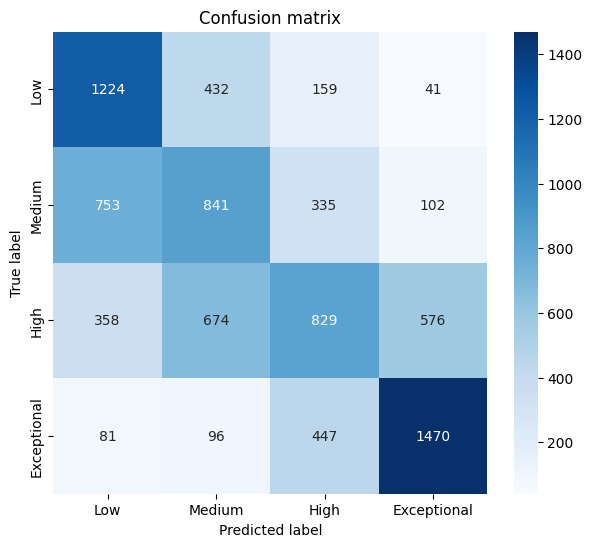

CPU times: total: 23min 48s
Wall time: 12min 13s


In [ ]:
class TSAILearner:

    def __init__(self, seed=42, max_learning_rate=0.01, num_epochs=150):
        """
        Initializes the TAILearner instance with provided configurations.
        """
        self.seed = seed
        self.max_learning_rate = max_learning_rate
        self.num_epochs = num_epochs
        self.seed_everything()

    def seed_everything(self):
        """
        Seeds all random number generators to ensure reproducibility.
        """
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def load_csv(self, filename):
        """
        Loads a CSV file from the specified base folder.
        """
        #base_folder = Path("/polyaxon-v1-data/workspaces/data/4 bin merged proxy revenue data")
        base_folder = Path("../data/06_models_specific_preprocessing/4_bins_v2")        
        
        return pd.read_csv(base_folder / filename, index_col=0, parse_dates=["date"])

    def drop_cols(self, df, string):
        """
        Drops columns from dataframe which contain the specified string.
        """
        cols_to_drop = [col for col in df.columns if string in col]
        return df.drop(cols_to_drop, axis=1)

    def load_data(self):
        """
        Loads training and test datasets.
        """
        # Loading datasets
        self.X_train = self.load_csv("X_train_8_bins_proxy_revenue_individual_binning.csv")
        self.X_test = self.load_csv("X_test_8_bins_proxy_revenue_individual_binning.csv")
        self.y_train = self.load_csv("y_train_8_bins_proxy_revenue_individual_binning.csv")
        self.y_test = self.load_csv("y_test_8_bins_proxy_revenue_individual_binning.csv")

        # Dropping unnecessary columns contain 'cost_centre_code'
        self.X_train = self.drop_cols(self.X_train, 'cost_centre_code')
        self.X_test = self.drop_cols(self.X_test, 'cost_centre_code')

        print(
            "X_train, X_test shape",
            type(self.X_train),
            self.X_train.shape,
            type(self.X_test),
            self.X_test.shape,
        )

        self.X = pd.concat([self.X_train, self.X_test])
        self.y = pd.concat([self.y_train, self.y_test])

        self.X, self.y, self.splits = combine_split_data(
            [self.X_train, self.X_test], [self.y_train, self.y_test]
        ) # so tsai uses X and y only and not X train and test etc. self.plits will contain the percentage of train and test splits. 
        self.y = self.y.values.flatten()

    def create_dls(self, tfms=[None, TSClassification()], batch_tfms=TSStandardize(), bs=[64, 128]): 
        """Creates a DataLoader for the time series data with specified transforms and batch sizes.
        1. tfms is transfomer. TSClassification: Vectorized, reversible transform of category string to vocab id.
        2. TSStandardize: Standardizes batch of type TSTensor.
        3. batch size
        """
        self.dls = get_ts_dls(
            torch.from_numpy(self.X.astype(np.float64)),
            torch.from_numpy(self.y),
            splits=self.splits, # here will split the X and y again.
            tfms=tfms,
            batch_tfms=batch_tfms,
            bs=bs,
        )

    def build_learner(self):
        """Builds a learner object with a LSTM model and accuracy metrics."""
        model = build_ts_model(LSTM, dls=self.dls)
        self.learn = Learner(self.dls, model, metrics=accuracy)

    def train(self):
        """Trains the model using a one-cycle policy with specified epochs and max learning rate."""
        self.learn.fit_one_cycle(
            self.num_epochs, lr_max=self.max_learning_rate)

    def export_model(self):
        """Exports the trained model to a specified path."""
        path = Path("../data/08_model_checkpoints/AZ_LSTM.pkl")
        path.parent.mkdir(parents=True, exist_ok=True)
        self.learn.export(path)

    def print_scores(self):
        """Calculates and prints the precision, recall, and accuracy of the model's predictions."""
        # Set the model to evaluation mode for model's predictions
        self.learn.model.eval()  
        preds, targs = self.learn.get_preds() 
        preds = np.argmax(preds, axis=1)

        accuracy = accuracy_score(targs, preds)
        precision = precision_score(targs, preds, average="macro")
        recall = recall_score(targs, preds, average="macro")

        print("Precision: {:.2%}".format(precision))
        print("Recall: {:.2%}".format(recall))
        print("Accuracy: {:.2%}".format(accuracy))
    
    def plot_performance_matrix(self):
        """Plots a confusion matrix for the model's predictions using descriptive labels."""
        target_mapping = {
            0: "Low",
            1: "Medium",
            2: "High",
            3: "Exceptional"
        }

        # Set the model to evaluation mode for model's predictions
        self.learn.model.eval()  
        preds, targs = self.learn.get_preds() 
        preds = np.argmax(preds, axis=1)

        # Compute the confusion matrix
        cm = confusion_matrix(targs, preds)

        # Plot the confusion matrix
        plt.figure(figsize=(7, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=target_mapping.values(),  
            yticklabels=target_mapping.values(),  
        )
        plt.title("Confusion matrix")
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.show()

    def run(self):
        """Runs the entire data processing, model building, training, and evaluation pipeline."""
        self.load_data()
        self.create_dls()
        self.build_learner()
        self.train()
        # self.export_model()
        self.print_scores()
        self.plot_performance_matrix()


if __name__ == "__main__":
    tsai_learner = TSAILearner(seed=24, max_learning_rate=0.01, num_epochs=30) #set the training parameters here
    tsai_learner.run()


## Experiment on latest dataset
- Location of data: `data/06_model_specific_preprocessing`
- Example used here: `v7_4_expand_30day_23_10_23`

### Stacked dataset v2 (4 bins & 30 epochs)
- CPU times: total: 23min 48s
- Wall time: 12min 13s
- Precision: 51.45%
- Recall: 52.89%
- Accuracy: 51.84% 

In [4]:
%%time
import random
import pandas as pd
import numpy as np
import torch
from tsai.all import *
from pathlib import Path
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

CPU times: user 368 µs, sys: 148 µs, total: 516 µs
Wall time: 524 µs


### 1. Prepare data
- Convert the `X_train`/`X_test` and `y_train`/`y_test` to `X` and `y` respectively. 
- Flatten `y` - convert it into a 1D array
- [`combine_split_data` reference](https://timeseriesai.github.io/tsai/data.validation.html)

In [5]:
def load_data(X_train, X_test, y_train, y_test):
    """
    Loads training and test datasets.
    """

    print(
        "X_train, X_test shape",
        type(X_train),
        X_train.shape,
        type(X_test),
        X_test.shape,
    )
    
    # Convert y to float or int
    mapping = {'Low': 0, 'Medium': 1, 'High': 2, 'Exceptional': 3}
    y_train['binned_proxyrevenue'] = y_train['binned_proxyrevenue'].map(mapping)
    y_test['binned_proxyrevenue'] = y_test['binned_proxyrevenue'].map(mapping)

    # combine and return the inital split ratios 
    X, y, splits = combine_split_data(
        [X_train, X_test], [y_train, y_test]
    )
    y = y.values.flatten()
    return X, y, splits

In [6]:
# Loading input data datasets
X_train = pd.read_csv("/polyaxon-v1-data/workspaces/jongching/working_branch/235_update-lstm-notebook-2/data/06_model_specific_preprocessing_no_ts_mm/ebm_model/train/training_fold1_expanding_window_param_X.csv", index_col=0, parse_dates=["Date"])
X_test = pd.read_csv("/polyaxon-v1-data/workspaces/jongching/working_branch/235_update-lstm-notebook-2/data/06_model_specific_preprocessing_no_ts_mm/ebm_model/validation/validation_fold1_expanding_window_param_X.csv", index_col=0, parse_dates=["Date"])
y_train = pd.read_csv("/polyaxon-v1-data/workspaces/jongching/working_branch/235_update-lstm-notebook-2/data/06_model_specific_preprocessing_no_ts_mm/ebm_model/train/training_fold1_expanding_window_param_y.csv", index_col=0, parse_dates=["Date"])
y_test = pd.read_csv("/polyaxon-v1-data/workspaces/jongching/working_branch/235_update-lstm-notebook-2/data/06_model_specific_preprocessing_no_ts_mm/ebm_model/validation/validation_fold1_expanding_window_param_y.csv", index_col=0, parse_dates=["Date"])

In [7]:
X, y, splits = load_data(X_train, X_test, y_train, y_test)

X_train, X_test shape <class 'pandas.core.frame.DataFrame'> (19893, 23) <class 'pandas.core.frame.DataFrame'> (1710, 23)


In [6]:
# outputs
print ("Train split:", len(splits[0]))
print ("Test split:", len(splits[1]))

Train split: 19893
Test split: 1710


### 2. Create data loader

#### 2.1. `TSClassification`
- A transformation or encoding method used for converting categorical string values into numerical values specifically for time series data or time series classification tasks ([reference](https://timeseriesai.github.io/tsai/data.core.html))

#### 2.2. `TSStandardize`
- Standardizes batch of type TSTensor ([reference](https://timeseriesai.github.io/tsai/data.preprocessing.html#tsstandardize))

Note that our current dataset has already been encoded and standardised. But to showcase `get_ts_dls` function, this notebook includes `TSClassification` and `TSStandardize`.

In [7]:
def create_dls(tfms=[None, TSClassification()], batch_tfms=TSStandardize(), bs=[64, 128]):
    """Creates a DataLoader for the time series data with specified transforms and batch sizes.
    1. convert X and y to PyTorch tensor
    2. splits: data splits for training and validation
    3. tfms: a list of transformation applied to the dataset. By default, the only transformation done is TSClassification()
    4. batch_tfms: transformations applied to batches of data. The default TSStandardize() implies standardization of batches.
    5. bs: defines batch sizes for training and validation data. The default [64, 128] sets two different batch sizes.
    """
    dls = get_ts_dls(
        torch.from_numpy(X.astype(np.float64)),
        torch.from_numpy(y),
        splits=splits,
        tfms=tfms,
        batch_tfms=batch_tfms,
        bs=bs,
    )
    return dls

In [8]:
dls = create_dls()

### 3. Build a learner and train model
- [`build_ts_model` reference](https://timeseriesai.github.io/tsai/models.utils.html#build_ts_model)
- [`Learner` reference](https://timeseriesai.github.io/tsai/learner.html)

In [9]:
def build_learner(dls):
    """Builds a learner object with a LSTM model and accuracy metrics."""
    model = build_ts_model(LSTM, dls=dls) # specify the model of interest and dataloader
    learn = Learner(dls, model, metrics=accuracy) # specify the metrics used for training
    return learn
def train(learn, num_epochs, max_learning_rate):
    """Trains the model using a one-cycle policy with specified epochs and max learning rate."""
    learn.fit_one_cycle(
        num_epochs, lr_max=max_learning_rate) # model training hyperparams
    return learn

In [10]:
model = build_learner(dls)
trained_model = train(model, num_epochs=5, max_learning_rate=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.371477,1.374065,0.312865,00:06
1,1.088212,1.161671,0.476608,00:07
2,1.090616,1.109860,0.456725,00:06
3,1.092260,1.110393,0.455556,00:06
4,1.064503,1.106058,0.461404,00:06


### 4. Model evaluation

In [11]:
def print_scores(trained_model):
    """Calculates and prints the precision, recall, and accuracy of the model's predictions."""
    # Set the model to evaluation mode for model's predictions
    trained_model.model.eval()  
    preds, targs = trained_model.get_preds() 
    preds = np.argmax(preds, axis=1)

    accuracy = accuracy_score(targs, preds)
    precision = precision_score(targs, preds, average="macro")
    recall = recall_score(targs, preds, average="macro")

    print("Precision: {:.2%}".format(precision))
    print("Recall: {:.2%}".format(recall))
    print("Accuracy: {:.2%}".format(accuracy))

def plot_performance_matrix(trained_model):
    """Plots a confusion matrix for the model's predictions using descriptive labels."""
    target_mapping = {
        0: "Low",
        1: "Medium",
        2: "High",
        3: "Exceptional"
    }

    # Set the model to evaluation mode for model's predictions
    trained_model.model.eval()  
    preds, targs = trained_model.get_preds() 
    preds = np.argmax(preds, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(targs, preds)

    # Plot the confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=target_mapping.values(), 
        yticklabels=target_mapping.values(), 
    )
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

Precision: 44.96%
Recall: 46.83%
Accuracy: 46.14%


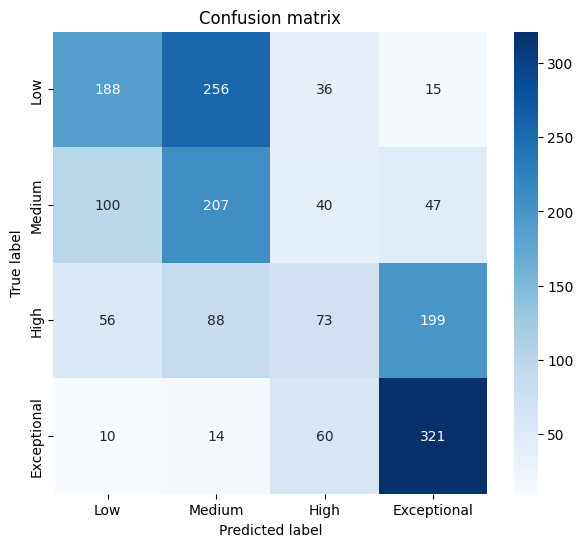

In [12]:
print_scores(trained_model)
plot_performance_matrix(trained_model)